In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from glob import glob

from itertools import chain

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(5)

## Load 'sample_labels.csv' data for pixel level assessments
#sample_df = pd.read_csv('sample_labels.csv')
#sample_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
109600,00029817_005.png,Infiltration,5,29817,67,F,AP,3056,2544,0.139,0.139,NaN
19233,00005090_000.png,Cardiomegaly,0,5090,54,F,PA,2500,2048,0.171,0.171,NaN
11119,00002880_000.png,No Finding,0,2880,31,M,PA,2500,2048,0.171,0.171,NaN
5195,00001382_003.png,Nodule,3,1382,27,M,AP,2048,2500,0.168,0.168,NaN
50869,00012864_009.png,Atelectasis|Effusion|Infiltration|Mass,9,12864,48,M,AP,2500,2048,0.168,0.168,NaN


In [3]:
## EDA

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
42180,00010845_000.png,No Finding,0,10845,32,M,PA,2606,2813,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10625,00002755_000.png,Fibrosis|Nodule,0,2755,59,M,PA,2500,2048,0.171,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
80683,00019823_000.png,Mass|Pleural_Thickening|Pneumothorax,0,19823,30,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [4]:
all_xray_df[all_labels].sum()

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

In [5]:
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

Here we see that within the 14 diseases listed, Pnuemonia cases amount to 1 percent of the total case number, with the highest occurences with diseases are Infiltration (~18 percent), Effusion (~12 percent), and Atelectasis (10 percent).
The occurence of no diseases is the highest result from these images, amounting to an occurence of 53 percent.
We should then structure the proportions of data within training and testing accordingly. For Training, we want 80% of the Pneumonia data and a proportionate amount of the cases which are not Pneumonia in a range similar to what we see in the overall distribution. For the Testing set, we want 20% of the total data set with the same amounts as would normally appear.

[Text(0, 0.5, 'Number of Images with Label')]

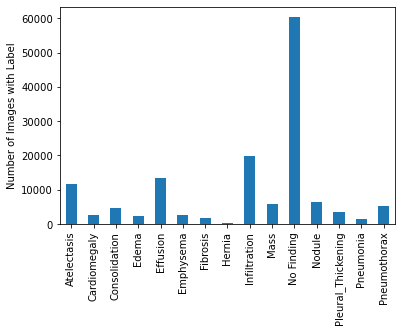

In [7]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

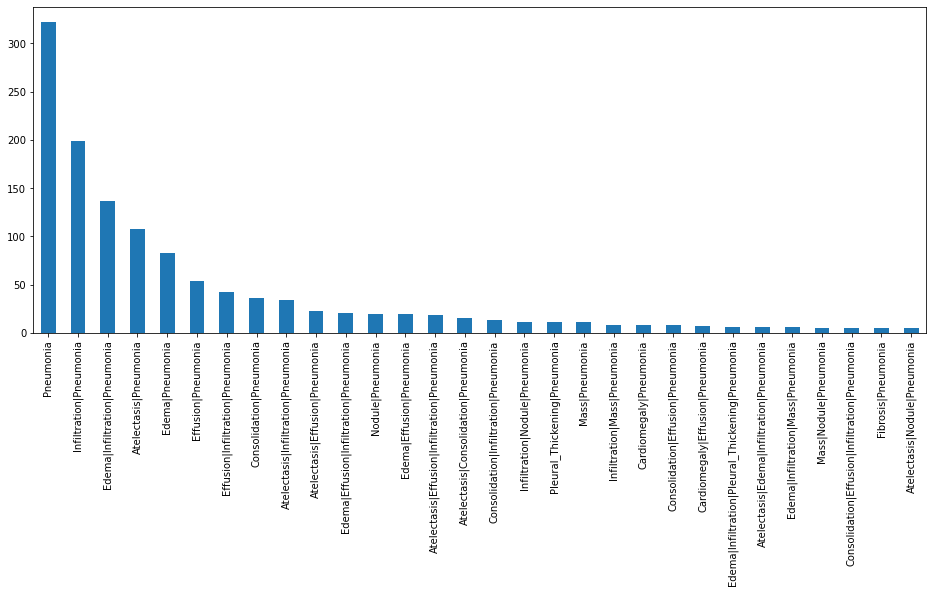

In [8]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

Within the individuals who have been seen with Pneumonia, the largest occurence is within individuals who solely have pneumonia. 
Within the rest of the occurences of Pneumonia, we see that Infiltration is the most common coocurrence, and it's presence with Edema is likewise fairly common. There are also a fairly large number of Pneumonia cases which coocurr with Atelectasis and with solely Edema. 
Given the high rates of Pneumonia's coocurrence with many of these other diseases, it is possible that our model may have trouble distinguishing between Pneumonia and these other conditions. Infiltration and Edema especially are likely to be challenging for our model due to their high rates of coocurrence. 

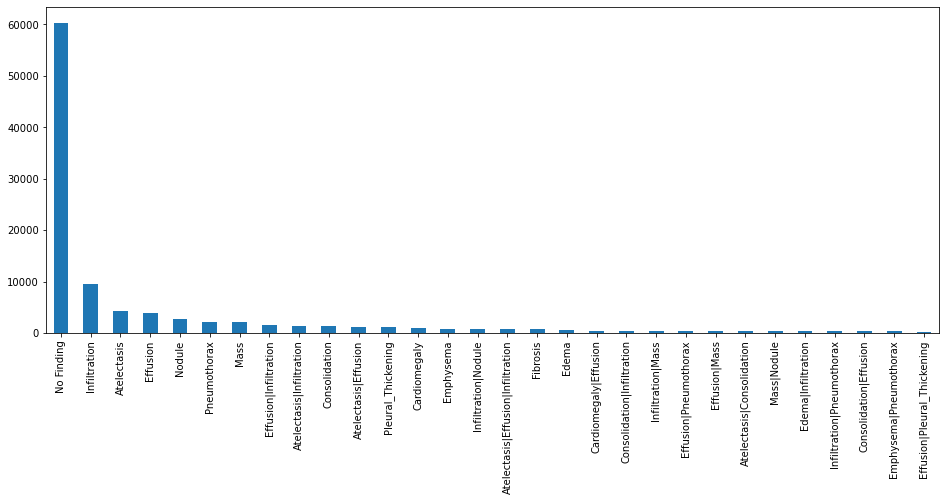

In [13]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==0]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

This graph displays the negatives in comparison to the previous positives we see in the graph previous. For individuals without pneumonia, the large majority will have no finding. 
It is important to note that the majority of these images are negatives, containing no finding in the majority of instances. We must be very careful when determining the ratio of positive and negative instances in our model, or otherwise it will almost certainly receive too many negative cases.

In [17]:
print("The ratio of negative cases to positive cases:")
len(all_xray_df[all_xray_df.Pneumonia==0])/len(all_xray_df[all_xray_df.Pneumonia==1])

The ratio of negative cases to positive cases:


77.35080363382251

(array([6.2800e+02, 1.5390e+03, 3.0740e+03, 5.0130e+03, 7.9780e+03,
        7.9890e+03, 9.7140e+03, 9.7810e+03, 1.4340e+04, 1.3604e+04,
        1.3797e+04, 1.2680e+04, 6.1750e+03, 4.0710e+03, 1.2060e+03,
        4.1900e+02, 8.7000e+01, 9.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([  1.  ,   6.45,  11.9 ,  17.35,  22.8 ,  28.25,  33.7 ,  39.15,
         44.6 ,  50.05,  55.5 ,  60.95,  66.4 ,  71.85,  77.3 ,  82.75,
         88.2 ,  93.65,  99.1 , 104.55, 110.  ]),
 <a list of 20 Patch objects>)

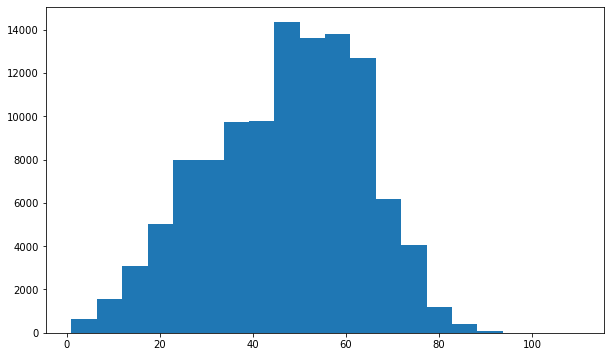

In [11]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], bins=20, range=(1, 110))

Within the general population of images in this set, we see a rough bell curve of cases centered around patients in their 50's, slightly sloped towards the lower end of the distribution.

(array([ 15.,  31.,  62.,  64., 128., 125., 132., 111., 165., 138., 161.,
        159.,  81.,  40.,  12.,   5.,   1.,   0.,   0.,   0.]),
 array([  1.  ,   6.45,  11.9 ,  17.35,  22.8 ,  28.25,  33.7 ,  39.15,
         44.6 ,  50.05,  55.5 ,  60.95,  66.4 ,  71.85,  77.3 ,  82.75,
         88.2 ,  93.65,  99.1 , 104.55, 110.  ]),
 <a list of 20 Patch objects>)

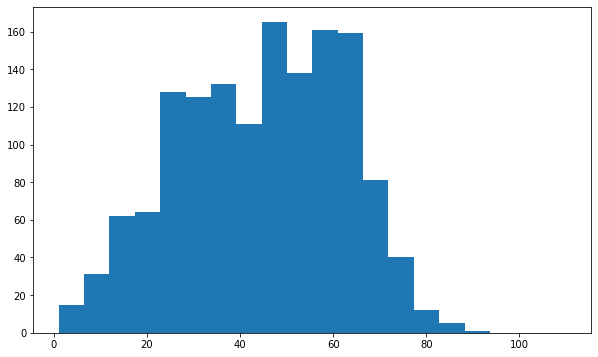

In [13]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df[all_xray_df.Pneumonia==1]['Patient Age'], bins=20, range=(1, 110))

For patients with Pneumonia, we see a tighter bell curve, in which the majority of patients are within the range of 20 - 70.
There are two spikes centered on 30 and roughly from 50 to the mid 60's, which reflects the original spike around the 50's range but suggests an increased number of patients within their 30's who have Pneumonia. 

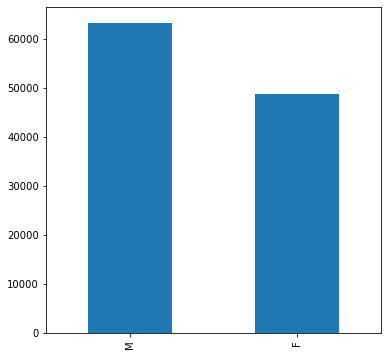

In [15]:
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

Within the general population of images, we see that there is a slight disparity between the number of male and female images, with there being roughly 1000 more male images

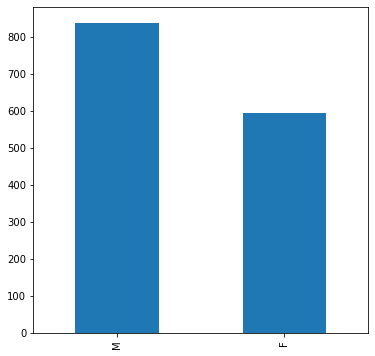

In [17]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts().plot(kind='bar')

The difference between the number male and female images has been slightly increased within the population who have pneumonia, with a roughly 200 more male images than female images.

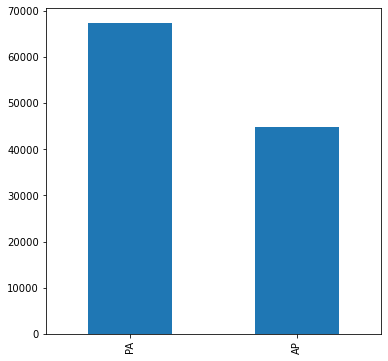

In [19]:
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')

Within the distribution of view positions, we see a tendency to pick PA but still a significant number of AP images as well, with the difference being roughly 2000 images

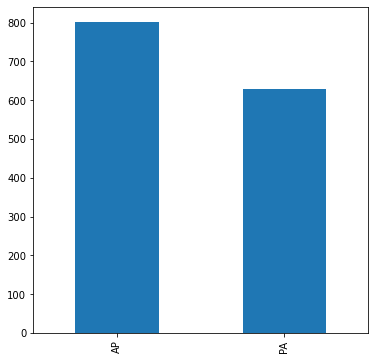

In [21]:
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia == 1]['View Position'].value_counts().plot(kind='bar')

Within cases of Pneumonia, we see a switch in which the majority of Pneumonia images are taken in AP rather than PA, which has roughly 150 fewer images than AP in this instance

Overall, the trends we see within the overall and Pneumonia sets should be represented in both the training and testing sets, though we should try to make sure that the training sets still contain an equal proportion of Pneumonia and non-Pneumonia cases.

In [6]:
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
45,00000246_016.png,Consolidation|Mass,16,246,051Y,M,PA,3056,2544,0.139000,0.139000
4002,00019762_000.png,No Finding,0,19762,054Y,M,PA,2992,2991,0.143000,0.143000
1781,00009403_005.png,Nodule|Pneumothorax,5,9403,057Y,M,PA,2500,2048,0.168000,0.168000
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
2742,00013731_004.png,Fibrosis|Mass,4,13731,048Y,M,PA,2992,2991,0.143000,0.143000


In [7]:
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)

In [26]:
hist = sample_df[sample_df["Finding Labels"].str.match('Pneumonia')]
data = []
for p in range(9):
    data.append(("pneumonia", hist.iloc[p]["path_img"]))

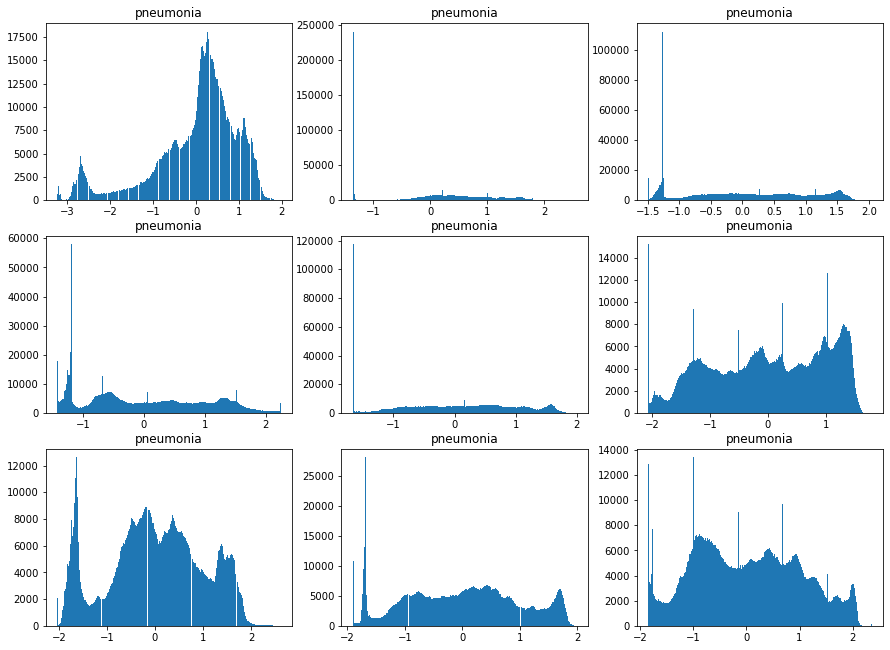

In [27]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('pneumonia')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

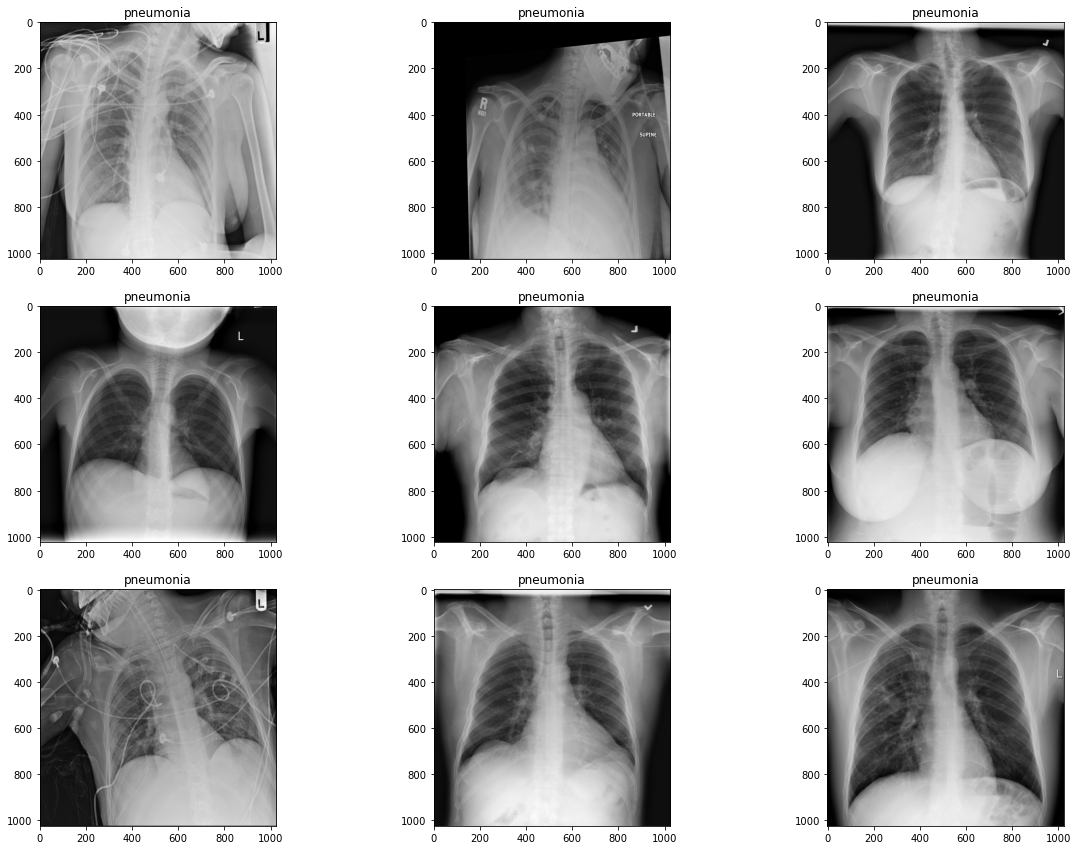

In [28]:
fig=plt.figure(figsize=(20, 20))
columns = 3
for j in range(len(data)):
    fig.add_subplot(len(data) / columns + 1, columns, j + 1).set_title('pneumonia')
    var = plt.imread(data[j][1])
    plt.imshow(var,cmap='gray')

In [29]:
hist = sample_df[sample_df["Finding Labels"].str.match('No Finding')]
data = []
for p in range(9):
    data.append(("no_finding", hist.iloc[p]["path_img"]))

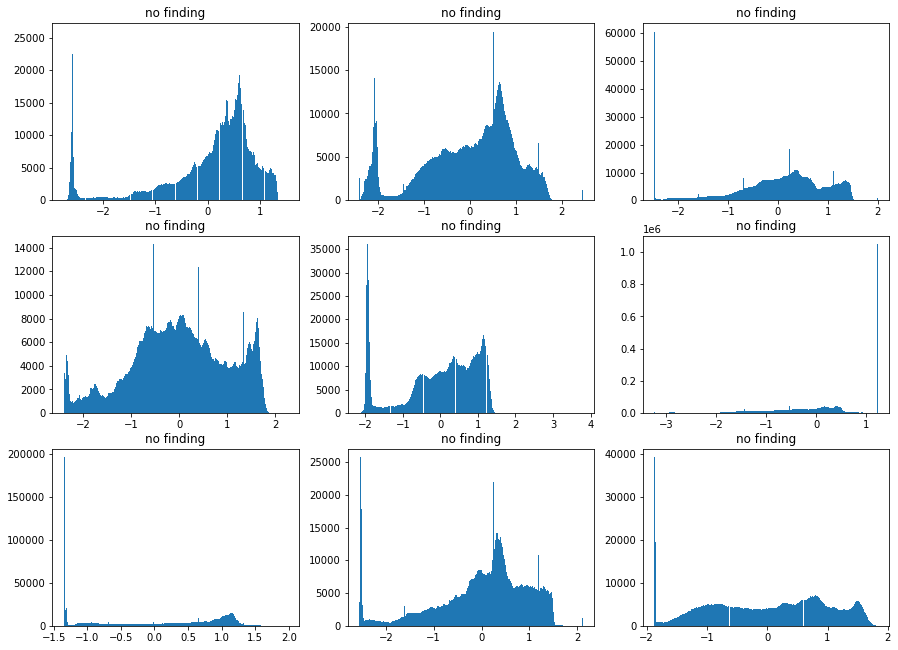

In [30]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('no finding')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

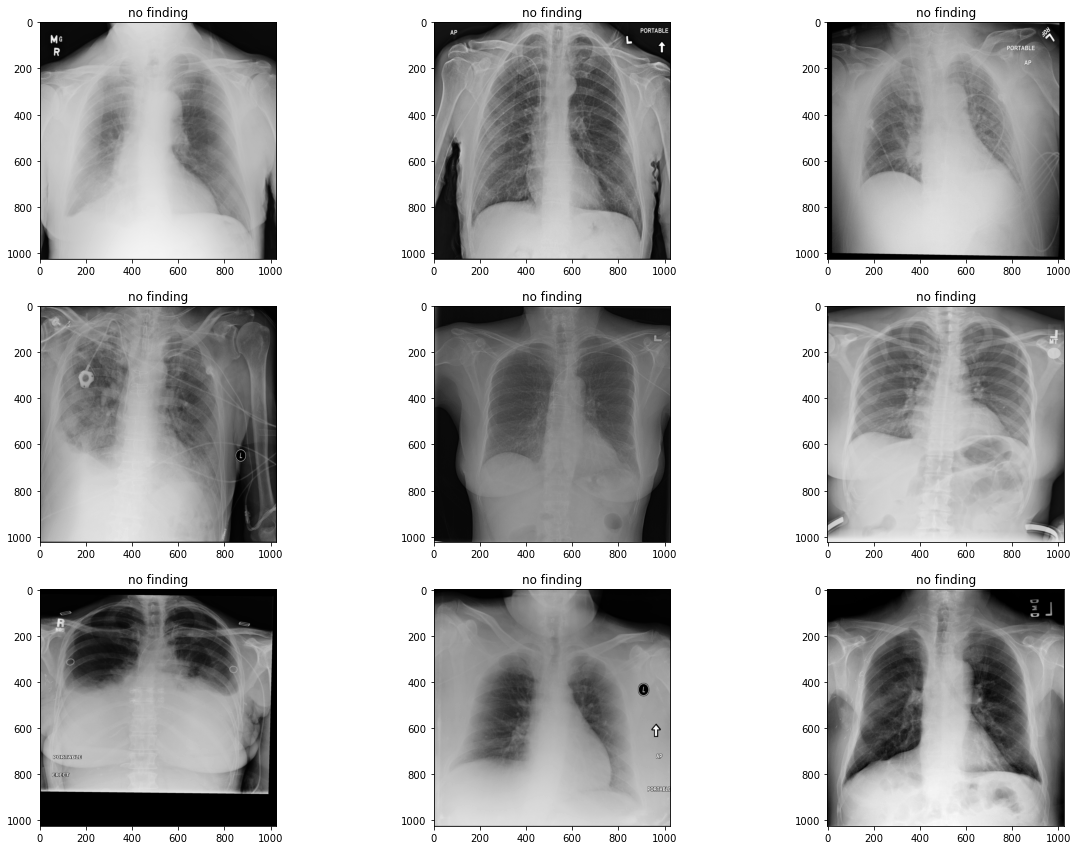

In [31]:
fig=plt.figure(figsize=(20, 20))
columns = 3
for j in range(len(data)):
    fig.add_subplot(len(data) / columns + 1, columns, j + 1).set_title('no finding')
    var = plt.imread(data[j][1])
    plt.imshow(var,cmap='gray')

In [32]:
hist = sample_df[sample_df["Finding Labels"].str.match('Infiltration')]
data = []
for p in range(9):
    data.append(("infiltration", hist.iloc[p]["path_img"]))

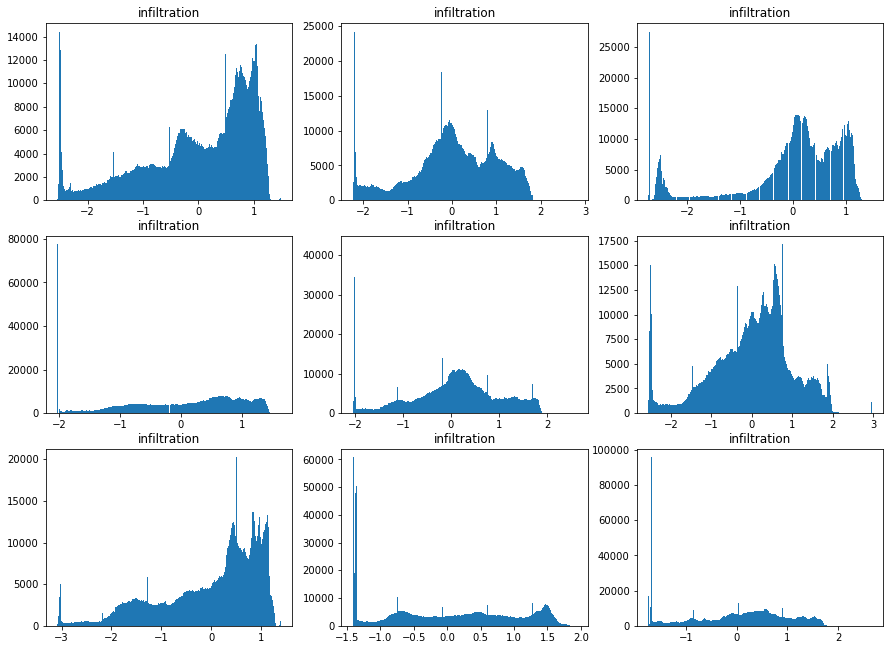

In [33]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('infiltration')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

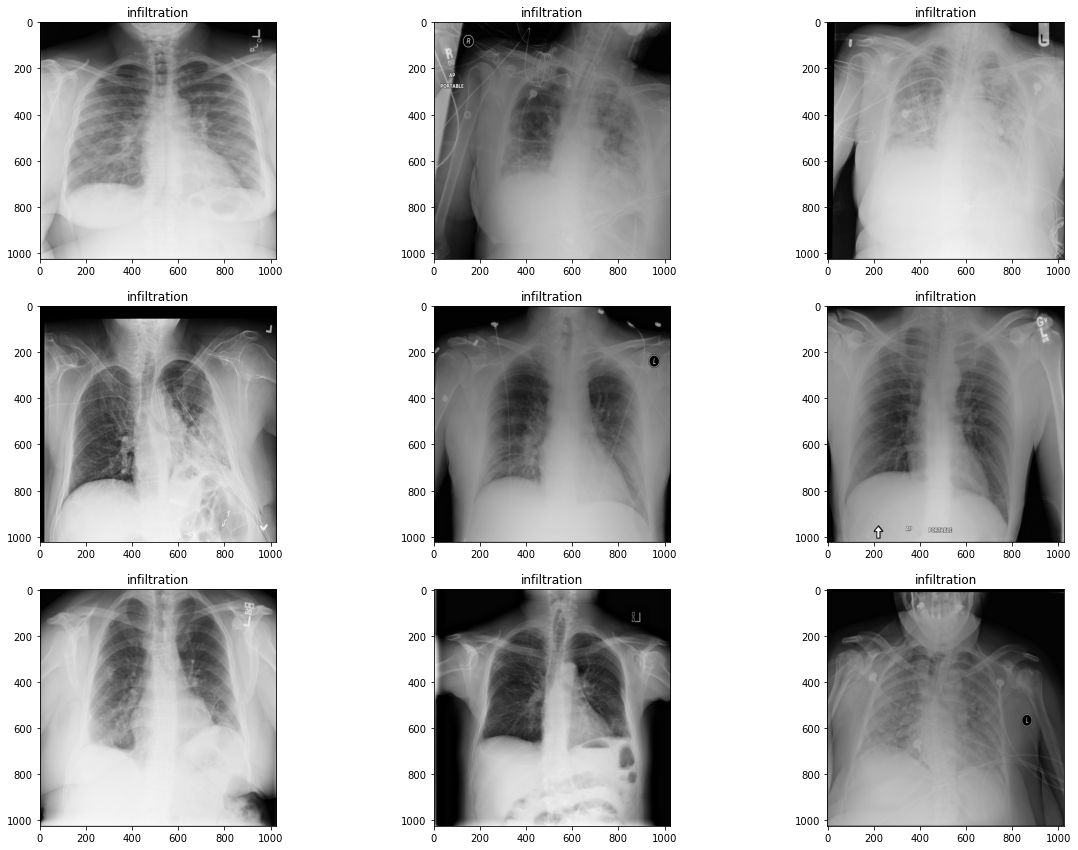

In [34]:
fig=plt.figure(figsize=(20, 20))
columns = 3
for j in range(len(data)):
    fig.add_subplot(len(data) / columns + 1, columns, j + 1).set_title('infiltration')
    var = plt.imread(data[j][1])
    plt.imshow(var,cmap='gray')

In [8]:
hist = sample_df[sample_df["Finding Labels"].str.match('Edema')]
data = []
for p in range(9):
    data.append(("edema", hist.iloc[p]["path_img"]))

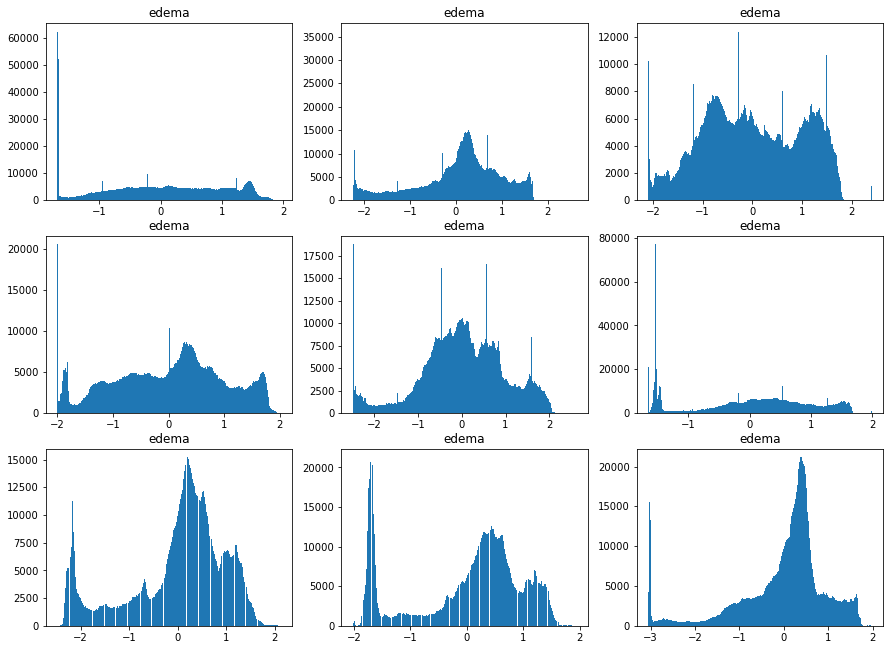

In [9]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('edema')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

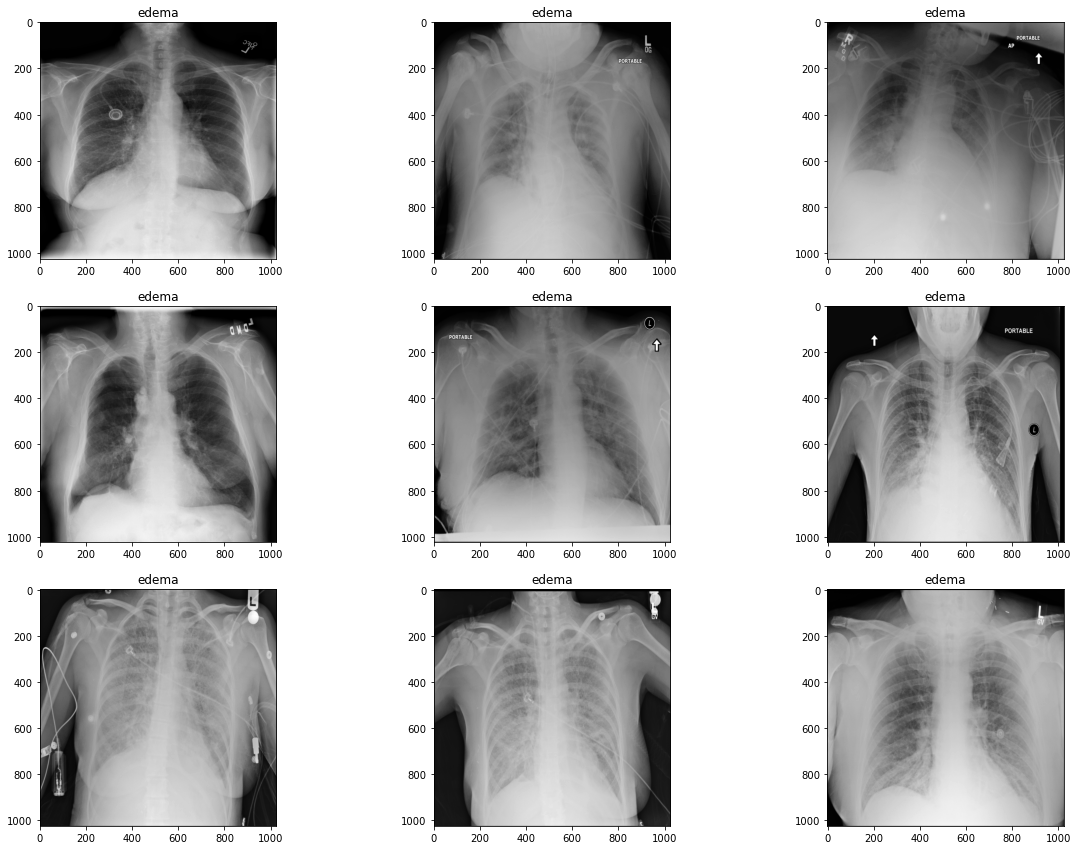

In [10]:
fig=plt.figure(figsize=(20, 20))
columns = 3
for j in range(len(data)):
    fig.add_subplot(len(data) / columns + 1, columns, j + 1).set_title('edema')
    var = plt.imread(data[j][1])
    plt.imshow(var,cmap='gray')

In [11]:
hist = sample_df[sample_df["Finding Labels"].str.match('Atelectasis')]
data = []
for p in range(9):
    data.append(("atelectasis", hist.iloc[p]["path_img"]))

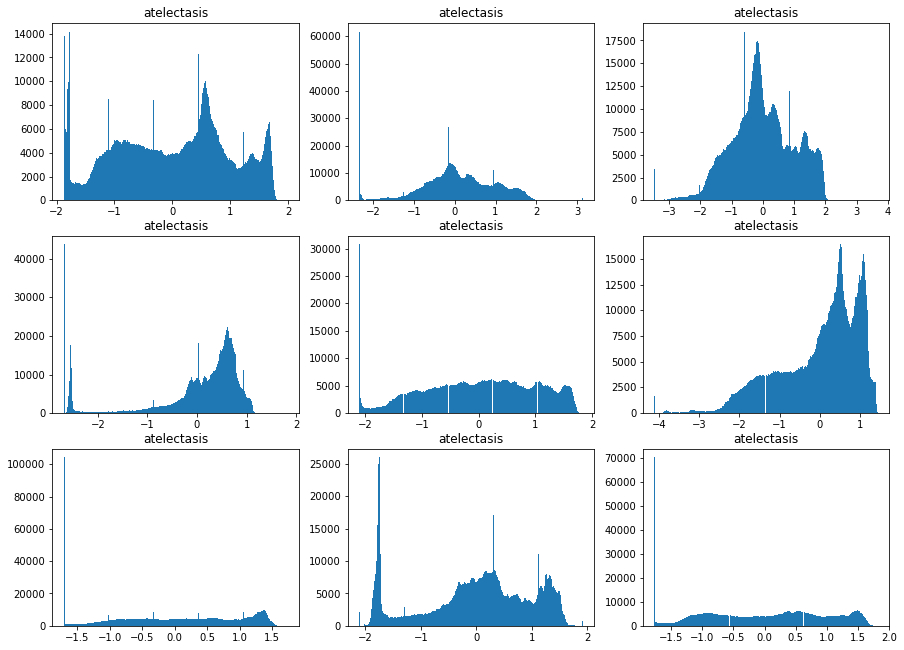

In [12]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('atelectasis')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

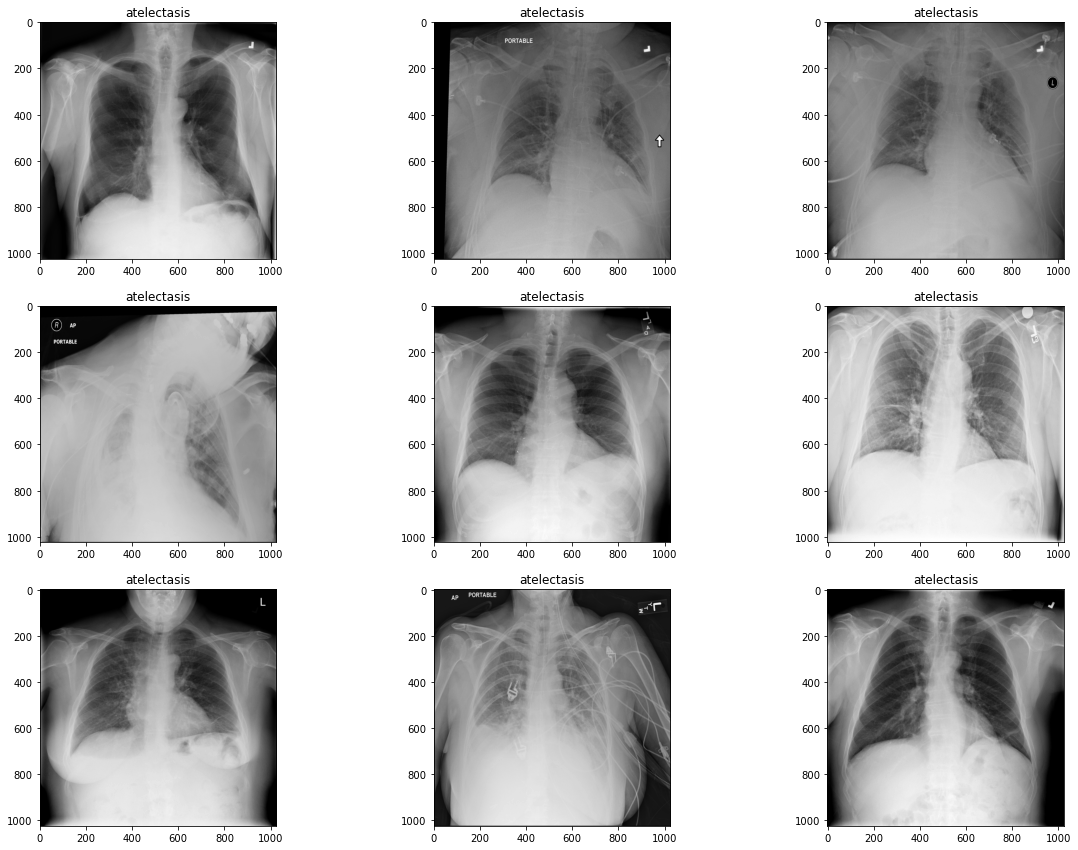

In [13]:
fig=plt.figure(figsize=(20, 20))
columns = 3
for j in range(len(data)):
    fig.add_subplot(len(data) / columns + 1, columns, j + 1).set_title('atelectasis')
    var = plt.imread(data[j][1])
    plt.imshow(var,cmap='gray')

In terms of findings from the pixel intensity plots and the corresponging images, we have learned that Infiltration, the most common disease and the one that most commonly cooccurs with Pnuemonia, has higher pixel intensities than those of Pneumonia. For Infiltration, the pixel intensities tend to spike between 10000 and 15000, often closer to 15000. For Pneumonia, the pixel intensities tend to spike closer to 8000 (with some exceptions). However, these are still remarkably similar in their overall shapes and the ranges of their spikes are still similar.
We see similar patterns to Infiltration in both Edema and Atelectasis, two other diseases which have high rates of coexistence with Pneumonia.
For cases with no findings, we see significantly more variability within the pixel intensities, ranging largely between 8000 and 15000. 

Due to the high rates of coexistence with Pneumonia and the overall similarities in their plots, the presence of Edema, Infiltration, and Atelectasis are improper for use in features of our model, as it may impact our Pneumonia detection negatively.